In [ ]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
np.random.seed(42)
tf.random.set_seed(42)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# **Pretrained Models for Transfer Learning**

- If you want to build an image classifier but you do not have enough training data, then it is often a good idea to reuse the lower layers of a pretrained model.

- Let's split the fashion MNIST training set in two:

- X_train_A: all images of all items except for sandals and shirts (classes 5 and 6).
- X_train_B: a much smaller training set of just the first 200 images of sandals or shirts.
- The validation set and the test set are also split this way, but without restricting the number of images.

- We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). 
- We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). 
- However, since we are using Dense layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image).

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

# Data Normalisation ==> make the mean 0 and std 1
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

# Either we do the above procedure or pixel value / 255.
# To reduce the pixel value we do this


X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
from collections import Counter
Counter(y_train)

Counter({0: 5479,
         1: 5503,
         2: 5510,
         3: 5492,
         4: 5473,
         5: 5497,
         6: 5533,
         7: 5550,
         8: 5485,
         9: 5478})

In [ ]:
Counter(y_valid)

Counter({0: 521,
         1: 497,
         2: 490,
         3: 508,
         4: 527,
         5: 503,
         6: 467,
         7: 450,
         8: 515,
         9: 522})

In [ ]:
Counter(y_test)

Counter({0: 1000,
         1: 1000,
         2: 1000,
         3: 1000,
         4: 1000,
         5: 1000,
         6: 1000,
         7: 1000,
         8: 1000,
         9: 1000})

In [ ]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6)  # sandal or shirts
    y_A = y[~y_5_or_6]  # all classes except 5 or 6
    # y_A: 0,1,2,3,4,7,8,9 ==> 0,1,2,3,4,5,6,7 
    y_A[y_A > 6] -= 2 
    # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # Only shirts
    # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))   # tuple(Dataset A), (Dataset B)

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [ ]:
X_train_A.shape

(43970, 28, 28, 1)

In [ ]:
X_train_B.shape

(200, 28, 28, 1)

In [ ]:
y_train_A[:30]

array([7, 0, 0, 3, 0, 2, 5, 2, 0, 7, 5, 7, 1, 0, 4, 3, 1, 4, 6, 4, 3, 0,
       2, 4, 4, 3, 0, 6, 2, 1], dtype=uint8)

In [ ]:
y_train_B[:30]

array([0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
       1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0.], dtype=float32)

In [ ]:
Counter(y_train_B)

Counter({0.0: 100, 1.0: 100})

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# MLP, Fully Connected NN
# 784 -- 300 -- 100 -- 50 -- 50 -- 50 -- 8
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation='relu'))
model_A.add(keras.layers.Dense(8, activation='softmax'))

In [ ]:
# sparse => we did not perform 1-hot encoding
model_A.compile(loss='sparse_categorical_crossentropy',
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=['accuracy'])

In [ ]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.4992 - accuracy: 0.8511 - val_loss: 0.3833 - val_accuracy: 0.8752
Epoch 2/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.3606 - accuracy: 0.8785 - val_loss: 0.3312 - val_accuracy: 0.8839
Epoch 3/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.3163 - accuracy: 0.8913 - val_loss: 0.2983 - val_accuracy: 0.8926
Epoch 4/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2918 - accuracy: 0.8997 - val_loss: 0.2874 - val_accuracy: 0.8963
Epoch 5/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2756 - accuracy: 0.9054 - val_loss: 0.2713 - val_accuracy: 0.9035
Epoch 6/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2630 - accuracy: 0.9099 - val_loss: 0.2645 - val_accuracy: 0.9030
Epoch 7/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2528 - accuracy: 0.9134 - val_loss: 0.2585 - val_accuracy:

In [ ]:
model_A.save('my_model_A.h5')

In [ ]:
# Binary classification, either shirt or sandal
# Without transfer learning
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation='relu'))
model_B.add(keras.layers.Dense(1, activation='sigmoid'))

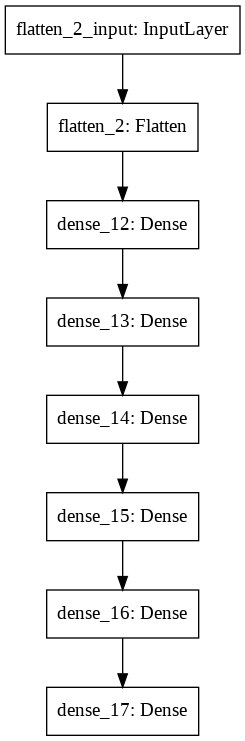

In [ ]:
tf.keras.utils.plot_model(model_B)

In [ ]:
model_B.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=['accuracy'])

In [ ]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 40ms/step - loss: 0.6967 - accuracy: 0.4978 - val_loss: 0.6976 - val_accuracy: 0.5289
Epoch 2/20
7/7 [==============================] - 0s 18ms/step - loss: 0.6900 - accuracy: 0.5308 - val_loss: 0.6900 - val_accuracy: 0.5485
Epoch 3/20
7/7 [==============================] - 0s 18ms/step - loss: 0.6836 - accuracy: 0.5971 - val_loss: 0.6831 - val_accuracy: 0.5845
Epoch 4/20
7/7 [==============================] - 0s 15ms/step - loss: 0.6741 - accuracy: 0.6513 - val_loss: 0.6760 - val_accuracy: 0.6196
Epoch 5/20
7/7 [==============================] - 0s 15ms/step - loss: 0.6732 - accuracy: 0.6872 - val_loss: 0.6692 - val_accuracy: 0.6289
Epoch 6/20
7/7 [==============================] - 0s 36ms/step - loss: 0.6620 - accuracy: 0.6727 - val_loss: 0.6630 - val_accuracy: 0.6505
Epoch 7/20
7/7 [==============================] - 0s 15ms/step - loss: 0.6549 - accuracy: 0.6887 - val_loss: 0.6568 - val_accuracy: 0.6825
Epoch 8/20
7/7 [===========

## **Transfer Learning**

- Transfer knowledge of model A onto dataset B
- Reuse the pre-trained model A

In [ ]:
model_A = keras.models.load_model('my_model_A.h5')
# Pre-trained model

# Transfer Learning
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
# Excluding the last layer

# Add our own output layer
model_B_on_A.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

# Back-propogation, to update the weights for all layers

model_B_on_A.compile(loss='binary_crossentropy',
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=['accuracy'])

In [ ]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/16
7/7 [==============================] - 1s 34ms/step - loss: 0.7166 - accuracy: 0.6493 - val_loss: 0.5719 - val_accuracy: 0.6979
Epoch 2/16
7/7 [==============================] - 0s 15ms/step - loss: 0.5161 - accuracy: 0.6817 - val_loss: 0.4472 - val_accuracy: 0.7608
Epoch 3/16
7/7 [==============================] - 0s 15ms/step - loss: 0.3605 - accuracy: 0.8031 - val_loss: 0.3624 - val_accuracy: 0.8206
Epoch 4/16
7/7 [==============================] - 0s 16ms/step - loss: 0.3151 - accuracy: 0.8358 - val_loss: 0.3035 - val_accuracy: 0.8567
Epoch 5/16
7/7 [==============================] - 0s 14ms/step - loss: 0.2801 - accuracy: 0.8780 - val_loss: 0.2638 - val_accuracy: 0.8804
Epoch 6/16
7/7 [==============================] - 0s 14ms/step - loss: 0.2264 - accuracy: 0.9152 - val_loss: 0.2370 - val_accuracy: 0.9093
Epoch 7/16
7/7 [==============================] - 0s 13ms/step - loss: 0.2119 - accuracy: 0.9149 - val_loss: 0.2176 - val_accuracy: 0.9216
Epoch 8/16
7/7 [===========

In [ ]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.5796 - accuracy: 0.7920


[0.5795884132385254, 0.7919999957084656]

In [ ]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.1406 - accuracy: 0.9680


[0.14060471951961517, 0.9679999947547913]

# **Using a Pretrained ResNet-50 Model**

- In general, you won’t have to implement standard models like GoogLeNet or ResNet manually, since pretrained networks are readily available with a single line of code in the keras.applications package. 
- For example, you can load the ResNet-50 model, pretrained on ImageNet, with the following line of code:

In [ ]:
model = keras.applications.resnet50.ResNet50(weights='imagenet')
# ResNet-50 model trained on ImageNet dataset

102973440/102967424 [==============================] - 0s 0us/step


- This will create a ResNet-50 model and download weights pretrained on the ImageNet dataset. 
- To use it, you first need to ensure that the images have the right size. 
- A ResNet-50 model expects 224 × 224-pixel images (other models may expect other sizes, such as 299 × 299), so let’s use TensorFlow’s tf.image.resize() function
to resize the images we loaded earlier:

In [ ]:
from sklearn.datasets import load_sample_image
import numpy as np

# Load sample images
china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

In [ ]:
batch_size

2

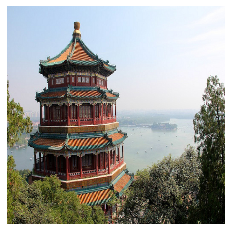

In [ ]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


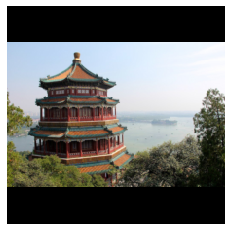

In [ ]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])
# To maintain the aspect ratio

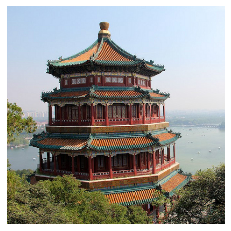

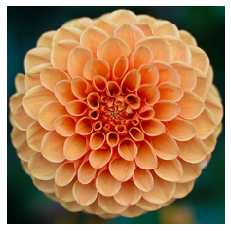

In [ ]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()


- The pretrained models assume that the images are preprocessed in a specific way. 
- In some cases they may expect the inputs to be scaled from 0 to 1, or –1 to 1, and so on.
- Each model provides a preprocess_input() function that you can use to preprocess your images. 
- These functions assume that the pixel values range from 0 to 255, so we must multiply them by 255 (since earlier we scaled them to the 0–1 range)

In [ ]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [ ]:
Y_proba.shape

(2, 1000)

In [ ]:
Y_proba[0, :10]

array([7.3548496e-09, 2.1553085e-08, 7.4699029e-09, 2.3163951e-09,
       7.3178241e-09, 9.3200612e-08, 8.9307292e-08, 1.8558953e-08,
       3.9790495e-09, 4.1840245e-08], dtype=float32)

- The output Y_proba is a matrix with one row per image and one column per class (in this case, there are 1,000 classes). 
- If you want to display the top K predictions, including the class name and the estimated probability of each predicted class, use the decode_predictions() function. 

- For each image, it returns an array containing the top K predictions, where each prediction is represented as an array containing the class identifier, its name, and the corresponding confidence score

In [ ]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
# Top-3 classes out of 1000 classes

for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

40960/35363 [==================================] - 0s 0us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



- As you can see, it is very easy to create a pretty good image classifier using a pre‐trained model. 

- Other vision models are available in keras.applications, including several ResNet variants, GoogLeNet variants like Inception-v3 and Xception,
VGGNet variants, and MobileNet and MobileNetV2 (lightweight models for use in mobile applications).

# **Pretrained Xception Model**

- Let’s train a model to classify pictures of flowers,
reusing a **pretrained Xception model**. 

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('tf_flowers', as_supervised=True, with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=3670>}

In [ ]:
info.splits['train']

<tfds.core.SplitInfo num_examples=3670>

In [ ]:
class_names = info.features['label'].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [ ]:
n_classes = info.features['label'].num_classes
n_classes

5

In [ ]:
dataset_size = info.splits['train'].num_examples
dataset_size

3670

In [ ]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=['train[:10%]', 'train[10%:25%]', 'train[25%:]'],
    as_supervised=True)

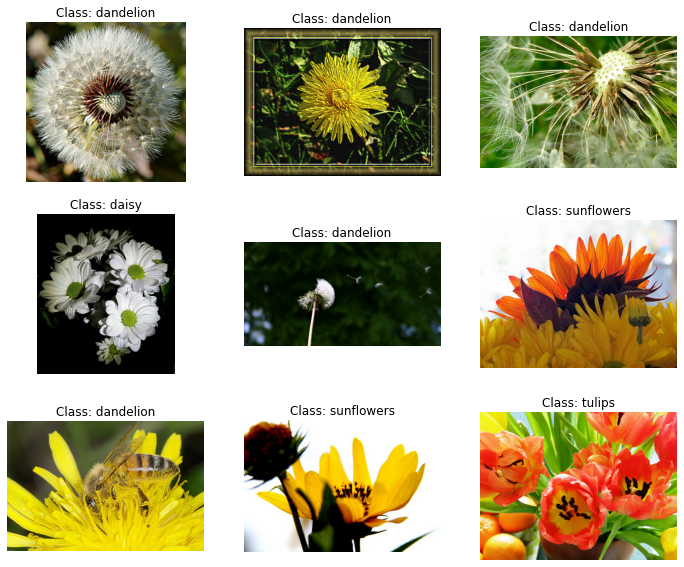

In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

- Basic preprocessing:

In [ ]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [ ]:
from functools import partial

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [ ]:
test_set_raw

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

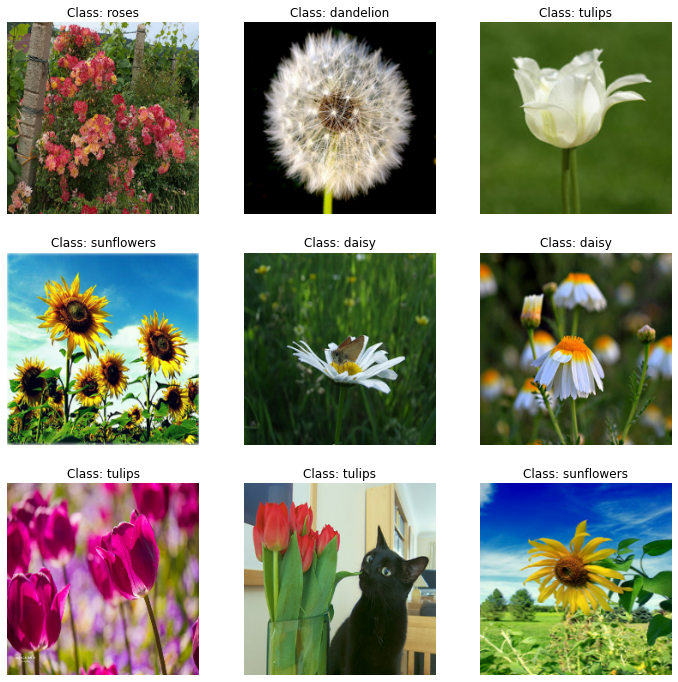

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):   # Taking the 1st batch
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

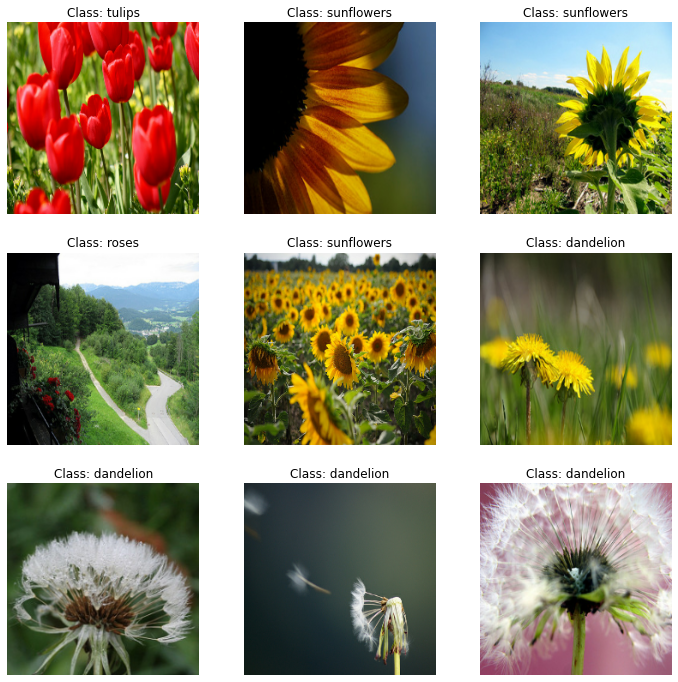

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

- Let’s load an Xception model, pretrained on ImageNet. 
- We exclude the top of the network by setting include_top=False: this excludes the global average pooling layer and the dense output layer. 
- We then add our own global average pooling layer, based
on the output of the base model, followed by a dense output layer with one unit per class, using the softmax activation function. 
- Finally, we create the Keras Model:

In [ ]:
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
# all layers except the top layers (pooling layer and dense layer)

# define our own pooling and dense layer
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(avg)

# Prepare the keras model
model = keras.models.Model(inputs=base_model.input, outputs=output)

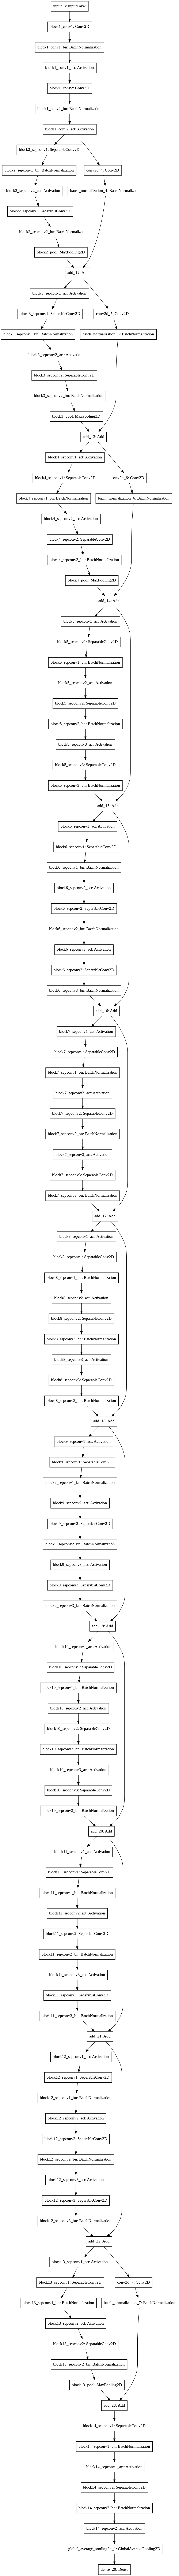

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_3
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_4
13 block2_pool
14 batch_normalization_4
15 add_12
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_5
23 block3_pool
24 batch_normalization_5
25 add_13
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_6
33 block4_pool
34 batch_normalization_6
35 add_14
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_15
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 19s 180ms/step - loss: 1.3439 - accuracy: 0.7075 - val_loss: 1.0816 - val_accuracy: 0.8309
Epoch 2/5
86/86 [==============================] - 15s 177ms/step - loss: 0.4884 - accuracy: 0.9056 - val_loss: 0.8589 - val_accuracy: 0.8493
Epoch 3/5
86/86 [==============================] - 16s 187ms/step - loss: 0.2493 - accuracy: 0.9431 - val_loss: 0.7175 - val_accuracy: 0.8566
Epoch 4/5
86/86 [==============================] - 17s 196ms/step - loss: 0.1128 - accuracy: 0.9630 - val_loss: 0.7073 - val_accuracy: 0.8750
Epoch 5/5
86/86 [==============================] - 17s 196ms/step - loss: 0.0741 - accuracy: 0.9773 - val_loss: 0.6717 - val_accuracy: 0.8824


In [ ]:
yp = model.predict(test_set)

In [ ]:
yp.shape

(367, 5)

In [ ]:
yp[:2, :]

array([[1.6327496e-12, 2.4688769e-12, 9.9990749e-01, 1.7280372e-12,
        9.2438662e-05],
       [2.9530723e-04, 4.2746413e-02, 1.2848097e-01, 8.1569725e-01,
        1.2779964e-02]], dtype=float32)

In [ ]:
for i in range(yp.shape[0]):
  pred = np.argmax(yp[i])
  print(class_names[pred])

tulips
sunflowers
sunflowers
tulips
sunflowers
dandelion
dandelion
dandelion
dandelion
daisy
roses
roses
roses
roses
daisy
daisy
roses
roses
roses
tulips
dandelion
dandelion
dandelion
tulips
dandelion
sunflowers
dandelion
daisy
daisy
tulips
tulips
daisy
dandelion
dandelion
daisy
daisy
dandelion
sunflowers
daisy
roses
tulips
sunflowers
dandelion
roses
sunflowers
sunflowers
tulips
roses
dandelion
daisy
tulips
daisy
sunflowers
dandelion
roses
roses
roses
dandelion
tulips
sunflowers
dandelion
dandelion
sunflowers
dandelion
daisy
daisy
dandelion
daisy
sunflowers
roses
tulips
sunflowers
dandelion
sunflowers
tulips
tulips
daisy
dandelion
sunflowers
tulips
dandelion
dandelion
roses
sunflowers
dandelion
sunflowers
sunflowers
tulips
dandelion
tulips
daisy
roses
dandelion
sunflowers
dandelion
sunflowers
daisy
roses
dandelion
roses
roses
roses
roses
dandelion
roses
tulips
sunflowers
roses
dandelion
dandelion
roses
roses
roses
tulips
tulips
roses
sunflowers
sunflowers
sunflowers
dandelion
sunflower

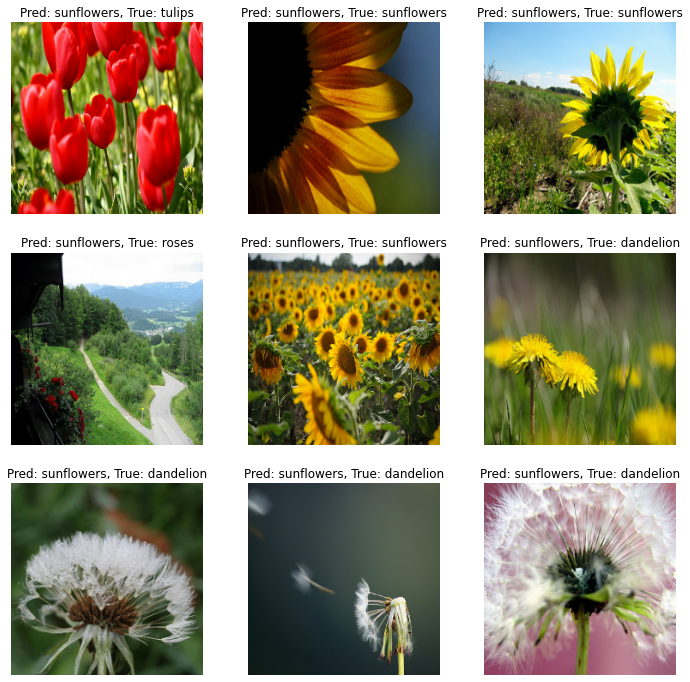

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index]/ 2 + 0.5)
        plt.title("Pred: {}, True: {}".format(class_names[pred], class_names[y_batch[index]]))
        plt.axis("off")

plt.show()